

# 生成对抗网络

在这本笔记本中，我们将建立一个针对MNIST数据集训练的生成对抗网络（GAN）。从此，我们将能够生成新的手写数字！

来自Ian Goodfellow和Yoshua Bengio实验室的其他人员在2014年首次报道了GAN（https://arxiv.org/abs/1406.2661 ）（https://arxiv.org/abs/1406.2661 ）。此后，GAN已经爆炸式爆发。以下是几个例子：

* [Pix2Pix]（https://affinelayer.com/pixsrv/ ）
* [CycleGAN]（https://github.com/junyanz/CycleGAN ）
* [整个列表]（https://github.com/wiseodd/generative-models ）

GANs背后的想法是，您有两个网络，一个生成器$ G $和一个鉴别器$ D $，彼此竞争。发生器使假数据传递给鉴别器。鉴别器还可以看到真实的数据，并预测其接收到的数据是真实还是假的。训练生成器来愚弄鉴别器，它希望输出尽可能靠近实际数据的数据。并且对该鉴别器进行训练以确定哪些数据是真实的，哪个是假的。最终发生的是，生成器学习使得不能从实际数据到鉴别器的数据。

![GAN diagram](assets/gan_diagram.png)

GAN的一般结构如上图所示，使用MNIST图像作为数据。潜在的样本是发生器用来构成假图像的随机矢量。随着生成器通过训练学习，它计算出如何将这些随机向量映射到可以欺骗鉴别器的可识别图像。

鉴别器的输出是S形函数，其中0表示假图像，1表示真实图像。如果您只对生成新图像感兴趣，则可以在训练后丢弃鉴别器。现在，我们来看看我们如何在TensorFlow中构建这个东西。

In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 模型输入

首先我们需要为我们的图形创建输入。 我们需要两个输入，一个用于鉴别器，一个用于发生器。 这里我们将调用鉴别器输入`inputs_real`和生成器输入`inputs_z`。 我们将为每个网络分配适当的大小。

> **练习：**完成下面的`model_inputs`函数。 使用输入大小“real_dim”和“z_dim”分别为`inputs_real`和`inputs_z`创建占位符。

In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    
    return inputs_real, inputs_z

 

## 生成器网络

![GAN Network](assets/gan_network.png)

在这里我们将构建生成器网络。为了使这个网络成为通用函数逼近器，我们至少需要一个隐藏层。我们应该使用一个泄漏的ReLU来让梯度顺畅地向下流过层。一个泄漏的ReLU就像一个正常的ReLU，除了负输入值有一个小的非零输出。

#### 可变范围
这里我们需要使用`tf.variable_scope`有两个原因。首先，我们要确保所有的变量名都以`generator`开头。同样，我们将在鉴别器变量前面加上“discriminator”。稍后，当我们对不同的网络进行培训时，这将有所帮助。

我们可以使用`tf.name_scope`来设置名称，但是我们也想用不同的输入重新使用这些网络。对于生成器，我们要训练它，但是在训练和训练之后也可以从这个_sample中获取。鉴别器将需要在假和真实输入图像之间共享变量。所以我们可以使用 `tf.variable_scope`

要使用`tf.variable_scope`，你可以使用`with`语句：
```python
with tf.variable_scope（'scope_name'，reuse = False）：
    # code here
```

以下是[TensorFlow文档]（https://www.tensorflow.org/programmers_guide/variable_scope#the_problem ）中的更多内容，以便使用`tf.variable_scope`进一步了解。

#### Leaky ReLU
TensorFlow不提供泄露ReLUs的操作，所以我们需要做一个。为此，您可以从线性完全连接的层获取输出，并将其传递到`tf.maximum`。通常，参数“alpha”设置负值的输出值。所以，负输入（`x`）值的输出是`alpha * x`，而正的`x`的输出是`x`：
$$
f(x) = max(\alpha * x, x)
$$

####  Tanh输出
发现生成器的发电机输出功率为$tanh$。这意味着我们必须将MNIST图像重新缩放到-1和1之间，而不是0和1。

> **练习：**在下面的函数中实现生成器网络。你需要返回tanh输出。确保将代码包装在可变范围内，以'generator'作为范围名称，并将`reuse`关键字参数从函数传递给`tf.variable_scope`。

In [5]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('generator',reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z,n_units,activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1*alpha,h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1,out_dim,activation=None)
        out = tf.tanh(logits)
        
        return out

## Discriminator

鉴别器网络与发生器网络几乎完全相同，只是我们使用S形输出层。

> **练习：**在下面的功能中实现鉴别器网络。 与上述相同，您需要返回对数和Sigmoid输出。 确保将代码包装在可变范围内，使用“discriminator”作为范围名称，并将`reuse`关键字参数从函数参数传递给`tf.variable_scope`。

In [7]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator',reuse=reuse):
        # Hidden layer
        h1 =tf.layers.dense(x,n_units,activation=None)
        # Leaky ReLU
        h1 =tf.maximum(h1*alpha,h1)
        
        logits =tf.layers.dense(h1,1,activation=None)
        out =tf.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [8]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

## 建立网络

现在我们正在从上面定义的函数构建网络。

首先是使用输入和z的大小从`model_inputs`获取我们的输入`input_real，input_z`。

然后，我们将创建生成器`generator（input_z，input_size）`。 这样可以使用适当的输入和输出尺寸构建发电机。

然后是歧视者。 我们将构建其中的两个，一个用于真实数据，一个用于假数据。 由于我们希望实数和假数据的权重相同，所以我们需要重用变量。 对于假数据，我们从生成器中获取`g_model`。 所以真正的数据鉴别器是“鉴别器（input_real）”，假鉴别器是“鉴别器（g_model，reuse = True）”。

> **练习：**从您之前定义的函数构建网络。

In [9]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size,z_size)

# Generator network here
g_model = generator(input_z,input_size, n_units=g_hidden_size, alpha=alpha)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)


## 鉴别器和发生器损失

现在我们需要计算损失，这有点棘手。对于鉴别器，总损耗是实际和假图像的损耗之和，`d_loss = d_loss_real + d_loss_fake`。 Sigmoid交叉熵的损失，我们可以用`tf.nn.sigmoid_cross_entropy_with_logits`获得。我们还将在“tf.reduce_mean”中包装，以获得批次中所有图像的平均值。所以损失会看起来像

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

对于真实的图像逻辑，我们将使用我们从上面的单元格中的鉴别器获得的`d_logits_real`。对于标签，我们希望它们是所有标签，因为这些都是真实的图像。为了帮助鉴别器更好地泛化，标签从1.0减少到0.9，例如使用参数`smooth`。这被称为标签平滑，通常与分类器一起使用以提高性能。在TensorFlow中，它看起来像`labels = tf.ones_like（tensor）*（1 - smooth）`

假数据的鉴别器丢失是类似的。逻辑是`d_logits_fake`，我们从发送器输出传递给鉴别器。这些假的对象与所有零的标签一起使用。请记住，我们希望鉴别器为真实图像输出1，为假图像输出0，所以我们需要设置损耗来反映出来。

最后，发电机损耗正在使用`d_logits_fake`，即伪图像逻辑。但是，现在的标签都是这些标签。发生器试图愚弄鉴别器，所以它想要鉴别器输出假图像。

> **练习：**计算鉴别器和发生器的损耗。有两个鉴别器损耗，一个用于真实图像，一个用于假图像。对于真正的图像丢失，使用真实的对数和（平滑的）标签。对于假图像丢失，请使用带有全零标签的假日志。总鉴别器损失是这两个损失的总和。最后，发电机损耗再次使用来自鉴频器的假逻辑，但是这一次，标签是所有的，因为发电机想要愚弄鉴别器。

In [10]:
# Calculate losses
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))

d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real+d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))



## Optimizers

我们要分别更新生成器和鉴别器变量。因此，我们需要为每个部分获取变量，并为这两个部分构建优化器。要获得所有可修改的变量，我们使用`tf.trainable_variables（）`。这将创建我们在图中定义的所有变量的列表。

对于生成器优化器，我们只想要生成变量。我们过去的自己很好，并使用可变范围来使用`generator'启动我们所有的生成器变量名。所以，我们只需要从`tf.trainable_variables（）'中遍历列表，并保留以`generator`开头的变量。每个变量对象都有一个属性`name`，它将变量的名称保存为一个字符串（例如`var.name =='weights_0``）。

我们可以做一些类似于鉴别器的事情。鉴别器中的所有变量都以`discriminator'开始。

然后，在优化器中，我们将变量列表传递给`minimize`方法的`var_list`关键字参数。这告诉优化器仅更新列出的变量。像`tf.train.AdamOptimizer().minimize(loss, var_list=var_list)`一样，只会训练`var_list`中的变量。

> **练习：**以下，实现生成器和鉴别器的优化器。首先，您需要获取可列出的变量列表，然后将该列表分成两个列表，一个用于生成变量，另一个用于鉴别变量。最后，使用“AdamOptimizer”，为每个更新网络变量的网络创建一个优化器。

In [12]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
print(g_vars)
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

[<tf.Variable 'generator/dense/kernel:0' shape=(100, 128) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/dense_1/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'generator/dense_1/bias:0' shape=(784,) dtype=float32_ref>]


## Training

In [13]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3545... Generator Loss: 4.0603
Epoch 2/100... Discriminator Loss: 0.4505... Generator Loss: 2.3411
Epoch 3/100... Discriminator Loss: 0.4179... Generator Loss: 2.8753
Epoch 4/100... Discriminator Loss: 0.7352... Generator Loss: 1.9432
Epoch 5/100... Discriminator Loss: 0.7109... Generator Loss: 7.2000
Epoch 6/100... Discriminator Loss: 1.7200... Generator Loss: 4.1661
Epoch 7/100... Discriminator Loss: 2.2037... Generator Loss: 1.7897
Epoch 8/100... Discriminator Loss: 1.1498... Generator Loss: 1.1412
Epoch 9/100... Discriminator Loss: 1.1352... Generator Loss: 1.5053
Epoch 10/100... Discriminator Loss: 1.4451... Generator Loss: 2.5393
Epoch 11/100... Discriminator Loss: 0.9666... Generator Loss: 3.5364
Epoch 12/100... Discriminator Loss: 0.8737... Generator Loss: 3.3839
Epoch 13/100... Discriminator Loss: 2.1278... Generator Loss: 1.5728
Epoch 14/100... Discriminator Loss: 0.7404... Generator Loss: 2.0219
Epoch 15/100... Discriminator Loss: 1.0498.

## 训练损失

这里我们来看看发生器和鉴频器的训练损耗。

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

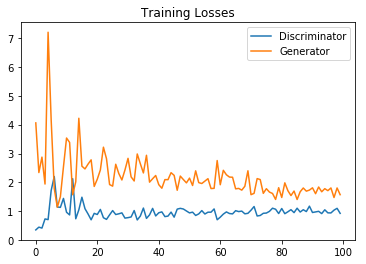

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.

In [16]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [17]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

这些是最后训练时期的样本。 您可以看到发生器能够再现像5,7,3,0，9这样的数字。由于这只是一个示例，它并不代表这个发生器可以产生的全部图像。

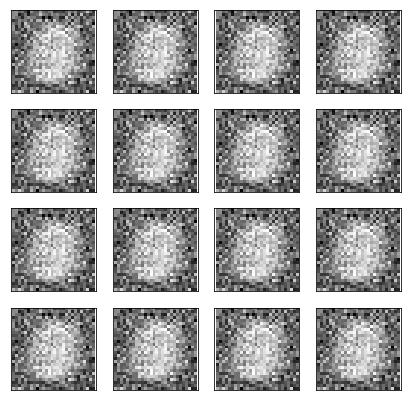

In [21]:
_ = view_samples(0, samples)

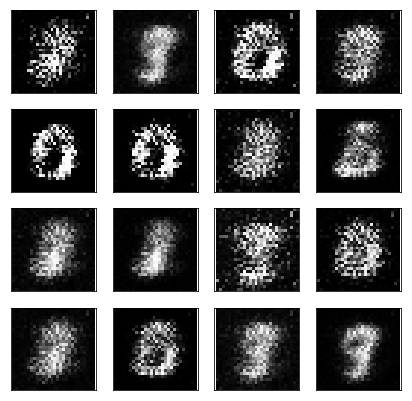

In [22]:
_ = view_samples(10, samples)

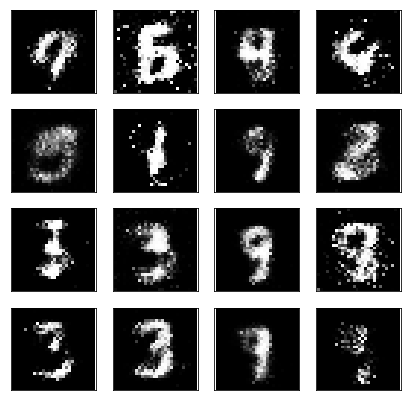

In [23]:
_ = view_samples(30, samples)

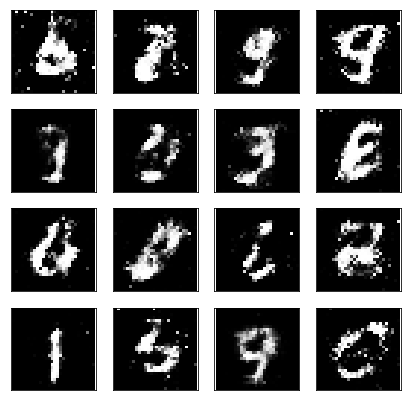

In [24]:
_ = view_samples(50, samples)

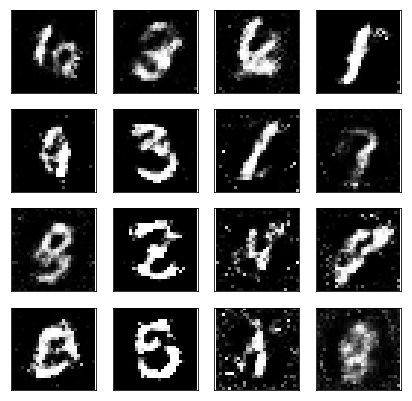

In [25]:
_ = view_samples(80, samples)

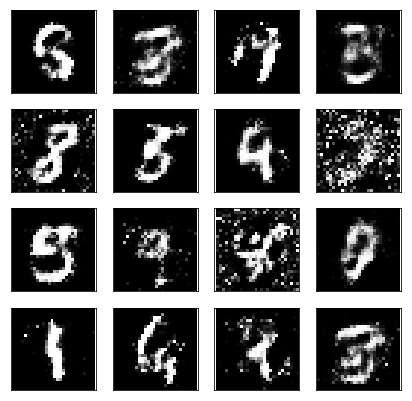

In [26]:
_ = view_samples(-1, samples)

下面我在网络训练时显示生成的图像，每10个纪元。 与奖金光学错觉！

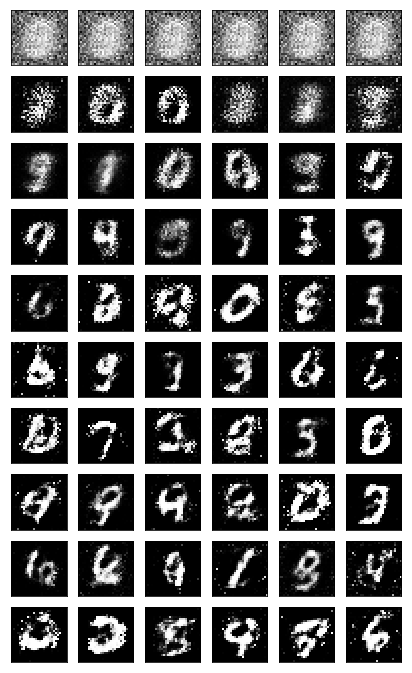

In [27]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

它开始是所有的噪音。 然后它学会使只有中心的白色和其余的黑色。 你可以开始看到一些数字，如结构出现的噪音。 看起来像1,9和8首先出现。 然后，它学习5和3。

 

## generator采样

我们还可以通过使用训练后保存的检查点，从发生器获取全新的图像。 我们只需要传递一个新的潜在矢量$z$，我们将得到新的样本！

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


(<matplotlib.figure.Figure at 0x125546898>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1260b2438>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x12389a7b8>]], dtype=object))

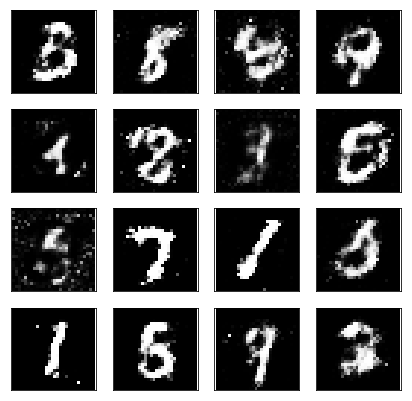

In [28]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])